#Imports and Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
import sklearn.decomposition

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
X_train = train_images
X_test = test_images
"""
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot
"""

label_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal',
             'Shirt','Sneaker','Bag','Ankle boot']


#2DLDA

In [ ]:
for i in range(50):
    L_prev = L.copy()
    SwR=np.zeros(X_tilda.shape)
    for i in range(X_tilda.shape[0]):
        A = X_tilda[i,:,:].dot(R)
        SwR[i,:,:] = A.dot(A.T)
    SwR = np.sum(SwR, axis = 0)

    #finds SbR
    SbR = np.zeros([10,28,28])
    for i in range(10):
        A = (globals()['M' +str(i)] - M).dot(R)   
        SbR[i,:,:] = 6000*A.dot(A.T)
    SbR = np.sum(SbR, axis=0)

    A = (np.linalg.inv(SwR)).dot(SbR)
    evals, evecs = np.linalg.eig(A) #cols of evecs are the eigen vectors
    L = evecs[:,:b]
    L = np.real(L) 

    ########################### L->R
    #finds SwL
    R_prev = R.copy()
    SwL=np.zeros(X_tilda.shape) 
    for i in range(X_tilda.shape[0]):
        A = X_tilda[i,:,:]
        SwL[i,:,:] = (A.T).dot(L).dot(L.T).dot(A)
    SwL = np.sum(SwL, axis = 0)

    #finds SbL
    SbL = np.zeros([10,28,28])
    for i in range(10):
        A = globals()['M' +str(i)] -M     
        SbL[i,:,:] = 6000*(A.T).dot(L).dot(L.T).dot(A)
    SbL = np.sum(SbL, axis=0)

    A = (np.linalg.inv(SwL)).dot(SbL)
    evals, evecs = np.linalg.eig(A) #cols of evecs are the eigen vectors
    R = evecs[:,:b]
    R = np.real(R)   

    if np.all( np.round(R,3) == np.round(R_prev,3)): break

9


In [ ]:
#transforms
Y_train = np.zeros([X_train.shape[0],b,b])
Y_test = np.zeros([X_test.shape[0],b,b])
for i in range(X_train.shape[0]):
    Y_train[i,:,:] = (L.T).dot(X_train[i,:,:].dot(R))

for i in range(X_test.shape[0]):
    Y_test[i,:,:] = (L.T).dot(X_test[i,:,:].dot(R))

#now vectorize
A = np.zeros([60000,b**2])
B = np.zeros([10000,b**2])
for i in range (60000):
    A[i,:] = Y_train[i,:,:].reshape([b**2])
for i in range (10000):
    B[i,:] = Y_test[i,:,:].reshape([b**2])

Y_train = A
Y_test = B


In [ ]:
k=4
model = KNeighborsClassifier(n_neighbors=k)
model.fit(Y_train, train_labels)
y_preds = model.predict(Y_test)
score=accuracy_score(y_true=test_labels, y_pred=y_preds)
score

0.8445

#Now to loop through all of it

In [ ]:
#initialize
M=np.mean(X_train[:,:,:] , axis=0)

for j in range(10): #M0, M1...
    Mj='M'+str(j)
    exec('%s=%d' % ( Mj ,0 ))
    globals()[Mj] = np.mean(X_train[train_labels==j ,:,:] , axis=0)     

X_tilda=np.zeros(X_train.shape)
for i in range(X_train.shape[0]):
    X_tilda[i,:,:] = X_train[i,:,:] - globals()['M' + str( train_labels[i] )]

#loops

for b in [6,8,10,12,14]:                                   #!!!!!!!!!!!!!
    R = np.eye(b)
    R = np.vstack( (R,np.zeros([28-b,b]) ))
    L = R.T
    #########!!!!!!!!!!!
    for i in range(50):
        L_prev = L.copy()
        SwR=np.zeros(X_tilda.shape)
        for i in range(X_tilda.shape[0]):
            A = X_tilda[i,:,:].dot(R)
            SwR[i,:,:] = A.dot(A.T)
        SwR = np.sum(SwR, axis = 0)

        #finds SbR
        SbR = np.zeros([10,28,28])
        for i in range(10):
            A = (globals()['M' +str(i)] - M).dot(R)   
            SbR[i,:,:] = 6000*A.dot(A.T)
        SbR = np.sum(SbR, axis=0)

        A = (np.linalg.inv(SwR)).dot(SbR)
        evals, evecs = np.linalg.eig(A) #cols of evecs are the eigen vectors
        L = evecs[:,:b]
        L = np.real(L) 

        ########################### L->R
        #finds SwL
        R_prev = R.copy()
        SwL=np.zeros(X_tilda.shape) 
        for i in range(X_tilda.shape[0]):
            A = X_tilda[i,:,:]
            SwL[i,:,:] = (A.T).dot(L).dot(L.T).dot(A)
        SwL = np.sum(SwL, axis = 0)

        #finds SbL
        SbL = np.zeros([10,28,28])
        for i in range(10):
            A = globals()['M' +str(i)] -M     
            SbL[i,:,:] = 6000*(A.T).dot(L).dot(L.T).dot(A)
        SbL = np.sum(SbL, axis=0)

        A = (np.linalg.inv(SwL)).dot(SbL)
        evals, evecs = np.linalg.eig(A) #cols of evecs are the eigen vectors
        R = evecs[:,:b]
        R = np.real(R)   

        if np.all( np.round(R,3) == np.round(R_prev,3)): break

    #transforms
    Y_train = np.zeros([X_train.shape[0],b,b])
    Y_test = np.zeros([X_test.shape[0],b,b])
    for i in range(X_train.shape[0]):
        Y_train[i,:,:] = (L.T).dot(X_train[i,:,:].dot(R))

    for i in range(X_test.shape[0]):
        Y_test[i,:,:] = (L.T).dot(X_test[i,:,:].dot(R))

    #now vectorize
    A = np.zeros([60000,b**2])
    B = np.zeros([10000,b**2])
    for i in range (60000):
        A[i,:] = Y_train[i,:,:].reshape([b**2])
    for i in range (10000):
        B[i,:] = Y_test[i,:,:].reshape([b**2])

    Y_train = A
    Y_test = B

    #now model time:
    for k in range(1,13): #(1,13):                       !!!!!!!!!!!!!!!!!!!!!!!!
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(Y_train, train_labels)
        y_preds = model.predict(Y_test)
        score=accuracy_score(y_true=test_labels, y_pred=y_preds)
        score
        print(score,'B',b,'k',k)

In [ ]:
"""
B 6 0.8283 k 1 0.8283
B 6 0.8245 k 2 0.8245
B 6 0.8411 k 3 0.8411
B 6 0.8445 k 4 0.8445
B 6 0.8466 k 5 0.8466
B 6 0.848 k 6 0.848
B 6 0.8468 k 7 0.8468
B 6 0.8447 k 8 0.8447
B 6 0.847 k 9 0.847
B 6 0.8464 k 10 0.8464
B 6 0.8498 k 11 0.8498
B 6 0.8488 k 12 0.8488
B 8 0.8446 k 1 0.8446
B 8 0.8409 k 2 0.8409
B 8 0.8508 k 3 0.8508
B 8 0.855 k 4 0.855
B 8 0.8529 k 5 0.8529
B 8 0.8541 k 6 0.8541
B 8 0.8569 k 7 0.8569
B 8 0.8554 k 8 0.8554
B 8 0.8568 k 9 0.8568
B 8 0.8563 k 10 0.8563
B 8 0.8555 k 11 0.8555
B 8 0.8549 k 12 0.8549
B 10 0.8537 k 1 0.8537
B 10 0.8516 k 2 0.8516
B 10 0.8597 k 3 0.8597
B 10 0.8623 k 4 0.8623
B 10 0.8634 k 5 0.8634
B 10 0.865 k 6 0.865
B 10 0.8644 k 7 0.8644
B 10 0.8638 k 8 0.8638
B 10 0.8646 k 9 0.8646
B 10 0.8649 k 10 0.8649
B 10 0.8634 k 11 0.8634
B 10 0.8615 k 12 0.8615
B 12 0.8597 k 1 0.8597
B 12 0.8537 k 2 0.8537
B 12 0.8633 k 3 0.8633
B 12 0.8647 k 4 0.8647
B 12 0.8675 k 5 0.8675
B 12 0.8688 k 6 0.8688
B 12 0.869 k 7 0.869
B 12 0.8685 k 8 0.8685
B 12 0.8666 k 9 0.8666
B 12 0.8661 k 10 0.8661
B 12 0.8662 k 11 0.8662
B 12 0.8669 k 12 0.8669
B 14 0.8593 k 1 0.8593
B 14 0.8566 k 2 0.8566
B 14 0.8677 k 3 0.8677
B 14 0.8663 k 4 0.8663
B 14 0.8665 k 5 0.8665
B 14 0.8688 k 6 0.8688
B 14 0.8684 k 7 0.8684
B 14 0.8675 k 8 0.8675
B 14 0.8667 k 9 0.8667
B 14 0.8666 k 10 0.8666
B 14 0.8649 k 11 0.8649
B 14 0.8657 k 12 0.8657
"""

Text(0, 0.5, 'Percent Error')

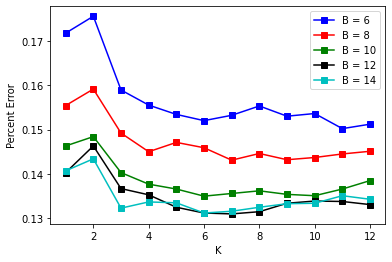

In [ ]:
B6_acc = [0.8283,0.8245,0.8411,0.8445,0.8466,0.848,
          0.8468,0.8447,0.847,0.8464,0.8498,0.8488]
B8_acc = [0.8446,0.8409,0.8508,0.855,0.8529,0.8541,
          0.8569,0.8554,0.8568,0.8563,0.8555,0.8549]
B10_acc= [0.8537,0.8516,0.8597,0.8623,0.8634,0.865,
          0.8644,0.8638,0.8646,0.8649,0.8634,0.8615]
B12_acc= [0.8597,0.8537,0.8633,0.8647,0.8675,0.8688,
          0.869,0.8685,0.8666,0.8661,0.8662,0.8669]
B14_acc= [0.8593,0.8566,0.8677,0.8663,0.8665,0.8688,
          0.8684,0.8675,0.8667,0.8666,0.8649,0.8657]

plt.plot(range(1,13), 1-np.array(B6_acc), '-bs', label='B = 6')
plt.plot(range(1,13), 1-np.array(B8_acc),'-rs', label = 'B = 8')
plt.plot(range(1,13), 1-np.array(B10_acc),'-gs', label = 'B = 10')
plt.plot(range(1,13), 1-np.array(B12_acc),'-ks', label = 'B = 12')
plt.plot(range(1,13), 1-np.array(B14_acc),'-cs', label = 'B = 14')

plt.legend()
plt.xlabel('K')
plt.ylabel('Percent Error')

Text(0, 0.5, 'Percent Error')

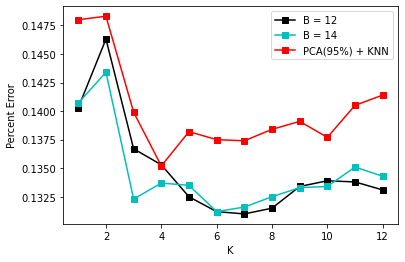

In [ ]:
KNN_acc = [0.852,0.8517,0.8601,0.8648,0.8618,0.8625,
           0.8626,0.8616,0.8609,0.8623,0.8595,0.8586]


plt.plot(range(1,13), 1-np.array(B12_acc),'-ks', label = 'B = 12')
plt.plot(range(1,13), 1-np.array(B14_acc),'-cs', label = 'B = 14')
plt.plot(range(1,13), 1-np.array(KNN_acc),'-rs', label = 'PCA(95%) + KNN')

plt.legend()
plt.xlabel('K')
plt.ylabel('Percent Error')